In [1]:
# ==============================================================================
# SECTION 1: SETUP AND IMPORTS
# This section imports all necessary libraries and configures the environment
# for GPU-accelerated training with PyTorch.
# ==============================================================================

# Core PyTorch libraries for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

# Torchvision for computer vision tasks, models, and image transformations
import torchvision
from torchvision import datasets, models, transforms

# Standard libraries for data manipulation, visualization, and system operations
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import time
from tqdm import tqdm

# Google Colab specific libraries for file handling and drive mounting
from google.colab import files
from google.colab import drive

In [2]:
# Set the device to a GPU if available, otherwise default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# ==============================================================================
# SECTION 2: DATA ACQUISITION
# This section handles the acquisition of the dataset from Kaggle.
# ==============================================================================

# --- Kaggle API Setup ---
# Configures the Kaggle API key to allow for direct dataset downloads.
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your kaggle.json file.")
    files.upload()

    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\nKaggle API configured successfully!")
else:
    print("Kaggle API is already configured.")


Kaggle API is already configured.


In [4]:
# --- Download and Unzip Dataset ---
# Cleans up old files and downloads a fresh copy of the dataset to prevent errors.
print("Downloading the dataset from Kaggle... (This may take a few minutes)")

!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
print("\nUnzipping the dataset...")

!unzip -q new-plant-diseases-dataset.zip -d .
print("\nDataset is ready! Let's check the contents:")
!ls 'New Plant Diseases Dataset(Augmented)'

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
new-plant-diseases-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)

Unzipping the dataset...
replace ./New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
Dataset is ready! Let's check the contents:
'New Plant Diseases Dataset(Augmented)'


In [6]:
# ==============================================================================
# SECTION 3: DATA PREPARATION
# This section defines the image preprocessing and augmentation pipelines
# and loads the data into PyTorch DataLoaders.
# ==============================================================================

# Define the correct path to the dataset directory
dataset_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = os.path.join(dataset_path, 'train')
valid_dir = os.path.join(dataset_path, 'valid')

# Define transformations for the training set with data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define transformations for the validation set (no augmentation)
valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Use ImageFolder to load data
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Store the class names for later use
class_names = train_dataset.classes

# Print a summary of the loaded data
print(f"\nNumber of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(valid_dataset)}")
print(f"Number of classes: {len(class_names)}")
print("\n--- Data is successfully prepared and ready for training! ---")


Number of training images: 70295
Number of validation images: 17572
Number of classes: 38

--- Data is successfully prepared and ready for training! ---


In [7]:

# ==============================================================================
# SECTION 4: MODEL DEFINITION
# This section loads a pre-trained ResNet18 model and prepares it for fine-tuning.
# ==============================================================================

model = models.resnet18(weights='IMAGENET1K_V1')

# Unfreeze the parameters in the last two convolutional blocks (layer3 and layer4)
# This allows the model to adapt its learned high-level features to our specific dataset.
for name, param in model.named_parameters():
    if "layer4" in name or "layer3" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace the final fully connected layer to match the number of classes in our dataset (38)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

# Move the model to the designated device (GPU)
model = model.to(device)

print("Model architecture is ready for fine-tuning.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 95.8MB/s]


Model architecture is ready for fine-tuning.


In [8]:
# ==============================================================================
# SECTION 5: TRAINING CONFIGURATION
# This section sets up the loss function, optimizer, and learning rate
# scheduler for the training process.
# ==============================================================================

# 1. Loss Function: CrossEntropyLoss is suitable for multi-class classification.
criterion = nn.CrossEntropyLoss()

# 2. Optimizer: Adam is used to update model weights. It will only update the parameters
#    where requires_grad is True (the layers we unfroze and the new classifier).
print("Parameters being trained:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

optimizer = optim.Adam(params_to_update, lr=0.001)

# 3. Learning Rate Scheduler: StepLR reduces the learning rate over time,
#    allowing for more precise adjustments as training progresses.
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

print("\nTraining components are configured.")

Parameters being trained:
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer3.1.bn2.bias
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias

Training components are configured.


In [9]:

# ==============================================================================
# SECTION 6: MODEL TRAINING
# This cell executes the training process, iterating through the dataset.
# ==============================================================================

# Set the number of training epochs
num_epochs = 20

# Record the start time for performance tracking
since = time.time()

# Initialize variables to store the best model weights and accuracy
best_model_wts = model.state_dict()
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Each epoch includes a training phase and a validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = train_loader
        else:
            model.eval()   # Set model to evaluation mode
            dataloader = valid_loader

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data batches
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass: calculate outputs and loss
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimization only occur in the training phase
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Update running statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate and print epoch-level loss and accuracy
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Save the model if it achieves a new best validation accuracy
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

    # Update the learning rate scheduler at the end of each epoch
    scheduler.step()
    print()

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:4f}')

# Load the best performing model weights
model.load_state_dict(best_model_wts)
print("Best model weights loaded.")

Epoch 1/20
----------


100%|██████████| 2197/2197 [05:31<00:00,  6.62it/s]


train Loss: 0.4335 Acc: 0.8674


100%|██████████| 550/550 [00:47<00:00, 11.66it/s]


val Loss: 0.1734 Acc: 0.9438

Epoch 2/20
----------


100%|██████████| 2197/2197 [04:55<00:00,  7.43it/s]


train Loss: 0.2336 Acc: 0.9271


100%|██████████| 550/550 [00:44<00:00, 12.29it/s]


val Loss: 0.0937 Acc: 0.9674

Epoch 3/20
----------


100%|██████████| 2197/2197 [04:56<00:00,  7.42it/s]


train Loss: 0.1884 Acc: 0.9403


100%|██████████| 550/550 [00:45<00:00, 12.05it/s]


val Loss: 0.0929 Acc: 0.9725

Epoch 4/20
----------


100%|██████████| 2197/2197 [04:58<00:00,  7.37it/s]


train Loss: 0.1591 Acc: 0.9498


100%|██████████| 550/550 [00:45<00:00, 12.02it/s]


val Loss: 0.0943 Acc: 0.9698

Epoch 5/20
----------


100%|██████████| 2197/2197 [05:02<00:00,  7.26it/s]


train Loss: 0.1462 Acc: 0.9538


100%|██████████| 550/550 [00:45<00:00, 12.05it/s]


val Loss: 0.0378 Acc: 0.9875

Epoch 6/20
----------


100%|██████████| 2197/2197 [05:01<00:00,  7.29it/s]


train Loss: 0.1237 Acc: 0.9606


100%|██████████| 550/550 [00:45<00:00, 12.06it/s]


val Loss: 0.0894 Acc: 0.9764

Epoch 7/20
----------


100%|██████████| 2197/2197 [05:03<00:00,  7.23it/s]


train Loss: 0.1196 Acc: 0.9615


100%|██████████| 550/550 [00:44<00:00, 12.39it/s]


val Loss: 0.0548 Acc: 0.9818

Epoch 8/20
----------


100%|██████████| 2197/2197 [04:57<00:00,  7.39it/s]


train Loss: 0.0673 Acc: 0.9777


100%|██████████| 550/550 [00:45<00:00, 12.10it/s]


val Loss: 0.0231 Acc: 0.9927

Epoch 9/20
----------


100%|██████████| 2197/2197 [04:55<00:00,  7.45it/s]


train Loss: 0.0547 Acc: 0.9821


100%|██████████| 550/550 [00:45<00:00, 12.02it/s]


val Loss: 0.0215 Acc: 0.9935

Epoch 10/20
----------


100%|██████████| 2197/2197 [04:53<00:00,  7.50it/s]


train Loss: 0.0505 Acc: 0.9836


100%|██████████| 550/550 [00:45<00:00, 11.99it/s]


val Loss: 0.0155 Acc: 0.9952

Epoch 11/20
----------


100%|██████████| 2197/2197 [04:53<00:00,  7.49it/s]


train Loss: 0.0486 Acc: 0.9838


100%|██████████| 550/550 [00:44<00:00, 12.38it/s]


val Loss: 0.0170 Acc: 0.9948

Epoch 12/20
----------


100%|██████████| 2197/2197 [04:52<00:00,  7.52it/s]


train Loss: 0.0454 Acc: 0.9847


100%|██████████| 550/550 [00:44<00:00, 12.44it/s]


val Loss: 0.0157 Acc: 0.9948

Epoch 13/20
----------


100%|██████████| 2197/2197 [04:51<00:00,  7.54it/s]


train Loss: 0.0432 Acc: 0.9852


100%|██████████| 550/550 [00:44<00:00, 12.45it/s]


val Loss: 0.0164 Acc: 0.9946

Epoch 14/20
----------


100%|██████████| 2197/2197 [04:50<00:00,  7.57it/s]


train Loss: 0.0397 Acc: 0.9868


100%|██████████| 550/550 [00:44<00:00, 12.41it/s]


val Loss: 0.0173 Acc: 0.9942

Epoch 15/20
----------


100%|██████████| 2197/2197 [04:48<00:00,  7.61it/s]


train Loss: 0.0402 Acc: 0.9865


100%|██████████| 550/550 [00:45<00:00, 11.96it/s]


val Loss: 0.0122 Acc: 0.9960

Epoch 16/20
----------


100%|██████████| 2197/2197 [04:52<00:00,  7.50it/s]


train Loss: 0.0370 Acc: 0.9874


100%|██████████| 550/550 [00:45<00:00, 12.04it/s]


val Loss: 0.0130 Acc: 0.9961

Epoch 17/20
----------


100%|██████████| 2197/2197 [04:52<00:00,  7.52it/s]


train Loss: 0.0367 Acc: 0.9880


100%|██████████| 550/550 [00:44<00:00, 12.25it/s]


val Loss: 0.0123 Acc: 0.9964

Epoch 18/20
----------


100%|██████████| 2197/2197 [04:51<00:00,  7.53it/s]


train Loss: 0.0376 Acc: 0.9878


100%|██████████| 550/550 [00:46<00:00, 11.93it/s]


val Loss: 0.0135 Acc: 0.9957

Epoch 19/20
----------


100%|██████████| 2197/2197 [04:47<00:00,  7.65it/s]


train Loss: 0.0369 Acc: 0.9875


100%|██████████| 550/550 [00:45<00:00, 12.13it/s]


val Loss: 0.0134 Acc: 0.9957

Epoch 20/20
----------


100%|██████████| 2197/2197 [04:48<00:00,  7.61it/s]


train Loss: 0.0376 Acc: 0.9871


100%|██████████| 550/550 [00:44<00:00, 12.33it/s]

val Loss: 0.0136 Acc: 0.9957

Training complete in 113m 49s
Best val Acc: 0.996358
Best model weights loaded.


In [10]:
# ==============================================================================
# SECTION 7: SAVE MODEL AND RUN PREDICTIONS
# This section saves the final model and demonstrates its use.
# ==============================================================================

# --- Save Model to Google Drive ---
drive.mount('/content/drive')
save_path = '/content/drive/My Drive/plant_disease_model_final.pth'

# Save the model's state dictionary, which contains all learned weights and biases
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Mounted at /content/drive
Model saved to /content/drive/My Drive/plant_disease_model_final.pth


In [11]:
# --- Prediction Function ---
def predict_image(image_path, model, class_names):
    """Predicts the class label for a single image."""
    # Open the image
    img = Image.open(image_path).convert('RGB')

    # Apply the same transformations as the validation set
    img_t = valid_transform(img)

    # Add a batch dimension, as the model expects batches of images
    batch_t = torch.unsqueeze(img_t, 0)
    batch_t = batch_t.to(device)

    # Set model to evaluation mode
    model.eval()

    # Get model output without calculating gradients
    with torch.no_grad():
        out = model(batch_t)

    # Find the index of the highest score, which corresponds to the predicted class
    _, predicted_idx = torch.max(out, 1)
    predicted_class = class_names[predicted_idx.item()]

    # Convert model output to probabilities to get a confidence score
    probabilities = torch.nn.functional.softmax(out, dim=1)
    confidence = probabilities[0][predicted_idx.item()] * 100

    return predicted_class, confidence

print("\nPrediction function defined.")


Prediction function defined.



--- Running a sample prediction ---


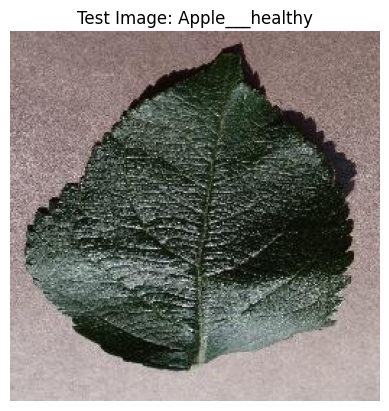

Predicted Class: Apple___healthy
Confidence: 100.00%


In [12]:
# --- Test Prediction on a Sample Image ---
print("\n--- Running a sample prediction ---")

# Select a test image (e.g., a healthy apple leaf)
test_class = 'Apple___healthy'
test_image_dir = os.path.join(valid_dir, test_class)
test_image_name = os.listdir(test_image_dir)[5]
test_image_path = os.path.join(test_image_dir, test_image_name)

# Display the test image
image = Image.open(test_image_path)
plt.imshow(image)
plt.title(f"Test Image: {test_class}")
plt.axis('off')
plt.show()

# Get and print the prediction
predicted_class, confidence = predict_image(test_image_path, model, class_names)
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")